# Linguistic study for logical fallacies
* We select top 2 logical fallacies on the basis of `% comment`. They are:
    * Fallacy of Relevance (red herring)
    * Faulty Generalization

* We also have the 11 hate categories (by grouping empath tokens and slur words as per the paper by Mainack Mondal Sir).

* Now for these top 2 fallacies and 11 hate triggers:
    * Study the top comments
    * Perform dependency parsing 
    

# Setup notebook environment

In [ ]:
# Mount Google drive to Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Clone `CreateDebateScraper` library from github for handling
# CreateDebate dataset
!git clone https://github.com/utkarsh512/CreateDebateScraper.git
%cd CreateDebateScraper/src/nested/

Cloning into 'CreateDebateScraper'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 176 (delta 5), reused 4 (delta 4), pack-reused 170
Receiving objects: 100% (176/176), 207.95 KiB | 2.17 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/CreateDebateScraper/src/nested


In [ ]:
# Install `cpnet` library for core-periphery analysis
!pip install cpnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
from   matplotlib import pyplot as plt
import seaborn as sns

from thread import (Comment,
                    Thread)

from collections import deque
from copy import deepcopy
import pickle
import json
from tqdm import tqdm
from pprint import pprint
from functools import lru_cache

import networkx as nx
import spacy
import cpnet
import nltk 

In [173]:
# Setup for plotting
sns.set(style='darkgrid')
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (18, 5)

# Setup for nltk
nltk.download('punkt') # For tokenizers
nltk.download('stopwords')
nltk.download('wordnet') # For lemmatizers
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

# Setup for spacy
!python -m spacy download en_core_web_sm
scapy_nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-27 22:37:35.909424: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-27 22:37:35.910609: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-27 22:37:35.910638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

# Load CreateDebate dataset

In [ ]:
comments = dict()

# Topical forums on CreateDebate. We have scraped comments for all of the
# following forurm.
categories = ['business', 'comedy', 'entertainment', 'health', 'law', 'nsfw',
              'politics2', 'religion', 'science', 'shopping', 'sports',
              'technology', 'travel', 'world']

# However, we will be analyzing comments from selected forum only!
# These forum have at least 10k comments each.
categories_selected = ['politics2', 'religion', 'world', 
                       'science', 'law', 'technology']

for x in categories_selected:
    comments[x] = list()

In [ ]:
# Loading comments from select forums

for cat in tqdm(categories_selected):
    fp = open('/content/gdrive/MyDrive/DL/CreateDebate/' + cat + '/threads.log', 'rb')

    # Get all the `Thread` objects pickled while scraping.
    threads = list()
    try:
        while True:
            e = pickle.load(fp)
            threads.append(e)
    except EOFError:
        fp.close()

    # While classifying CreateDebate comments, we used comments as per author mode.
    # Hence, using the same mode to attach classification score with the comments.
    # 
    # score < 0.5 -> ad hominem comment
    #       > 0.5 -> non ad hominem comment
    authors = dict()
    for thread in threads:
        for k, v in thread.comments.items():
            try:
                authors[v.author].append((v, k))
            except:
                authors[v.author] = list()
                authors[v.author].append((v, k))

    ctr = 0
    # Load the classification score of the comments.
    with open('/content/gdrive/MyDrive/DL/CreateDebate/' + cat + '/comments_with_score.log', 'rb') as fp:
        cws = pickle.load(fp)
    # Attach classification score with the comments.
    for author in authors.keys():
        for i in range(len(authors[author])):
            comment, cid = authors[author][i]
            foo = deepcopy(comment.__dict__)
            foo['tag'] = cat
            foo['score'] = cws[ctr][0]
            foo['validation'] = cws[ctr][1][0]
            foo['id'] = int(cid[3:])
            comments[cat].append(foo)
            ctr += 1

100%|██████████| 6/6 [00:18<00:00,  3.06s/it]


In [ ]:
# Get all usernames in a list
user_list = set()

for category in categories_selected:
    for comment in comments[category]:
        user_list.add(comment['author'])

user_list = list(user_list)

# Core-periphery setup

In [ ]:
# Get a list of all comment thread representative to build user network graph

threads = []

for category in categories_selected:
    reader_addr = f'/content/gdrive/MyDrive/DL/CreateDebate/{category}/threads.log'
    reader = open(reader_addr, 'rb')
    try:
        while True:
            e = pickle.load(reader)
            threads.append(e)
    except:
        reader.close()

In [ ]:
def build_graph(user_subset, n1 = 0, n2 = 0):
    """
    Builds user network graph from hyper-parameters n1 and n2
    
    Inputs
    ------
    :param n1: threshold on number of level-1 comments
    :param n2: threshold on number of direct replies

    Output
    ------
    (
        author_map: dict,
        reverse_map: list,
        author_count: int, 
        graph: nx.DiGraph,
        matrix: list
    )
    """

    # Uses globally defined `threads` variable to construct this dictionary.
    # You may choose which categories to be included while building `threads`

    # key  : author name
    # value: count of level-1 comments
    athr = dict()

    for e in threads:
        if 'root' in e.metaL.keys():
            for key in e.metaL['root'].keys():
                cmnt = e.comments[key]
                cur_athr = cmnt.author
                try:
                    athr[cur_athr] += 1
                except:
                    athr[cur_athr] = 1
        if 'root' in e.metaR.keys():
            for key in e.metaR['root'].keys():
                cmnt = e.comments[key]
                cur_athr = cmnt.author
                try:
                    athr[cur_athr] += 1
                except:
                    athr[cur_athr] = 1
    
    # Filter those authors who satisfy the contraint on number of level-1 comments
    L1_athr = dict()
    for x in athr:
        if athr[x] >= n1:
            L1_athr[x] = True

    # Now use `athr` for storing count of direct replies
    # key  : author name
    # value: count of direct replies received
    athr = dict()

    # Depth-first search utility to get number of direct replies for each author
    def dfs(Map, cmntMap, athr, cid='root'):
        if cid == 'root':
            for key in Map[cid].keys():
                dfs(Map[cid], cmntMap, athr, key)
            return

        cur_author = cmntMap[cid].author
        try:
            athr[cur_author] += len(Map[cid].keys())
        except:
            athr[cur_author] = len(Map[cid].keys())

        for key in Map[cid].keys():
            dfs(Map[cid], cmntMap, athr, key)

    # Traverse thread-tree to get number of direct replies for each author
    for e in threads:
        if 'root' in e.metaL.keys():
            dfs(e.metaL, e.comments, athr)
        if 'root' in e.metaR.keys():
            dfs(e.metaR, e.comments, athr) 
    
    # Filter authors who now satify both the contrainsts on count of 
    # - level-1 comments
    # - direct replies
    A = []
    for x in athr:
        if x not in user_subset:
            continue
        if athr[x] >= n2:
            try:
                z = L1_athr[x]
                A.append(x)
            except KeyError:
                pass

    # key  : author name
    # value: corresponing node number in the support/dispute network
    author_map = dict()

    # To get author name for node number
    reverse_map = ["" for _ in range(len(A))]
    author_count = len(A)

    for i in range(author_count):
        author_map[A[i]] = i
        reverse_map[i] = A[i]
    
    # Weighted adjacency matrices for user network
    # Weight for directed edge b/w Node A and Node B corresponsds to the number
    # of times Node A directly-replied Node B.
    matrix = [[0 for j in range(author_count)] for i in range(author_count)]

    # Depth-first search utility to build the adjacency matrices for graph.
    def dfs1(Map, cmntMap, cid='root'):
        if cid == 'root':
            for key in Map[cid].keys():
                dfs1(Map[cid], cmntMap, key)
            return

        cur_author = cmntMap[cid].author
        
        if cur_author in author_map:
            cur_author_id = author_map[cur_author]
            for key in Map[cid].keys():
                nxt_author = cmntMap[key].author
                if nxt_author in author_map:
                    nxt_author_id = author_map[nxt_author]
                    matrix[nxt_author_id][cur_author_id] += 1

        for key in Map[cid].keys():
            dfs1(Map[cid], cmntMap, key)

    for e in threads:
        if 'root' in e.metaL:
            dfs1(e.metaL, e.comments)
        if 'root' in e.metaR:
            dfs1(e.metaR, e.comments)
        
    # Create NetworkX graphs from the adjacency matrices.
    # We need nx graphs in order to get various network stats provided in nx
    # library.
    graph = nx.DiGraph()
    for i in range(author_count):
        for j in range(author_count):
            if matrix[i][j] != 0:
                graph.add_weighted_edges_from([(i, j, matrix[i][j])])
    
    return (author_map, reverse_map, author_count, graph, matrix)

In [ ]:
# Construct global user network for entire CreateDebate corpus
user_map, user_reverse_map, user_count, Graph, Matrix = build_graph(user_list)

In [ ]:
def get_coreness_dict(graph):
    """Get coreness value for each nodes as dictionary. We use Boyd algorithm.
    :param graph: networkX graph instance

    For more info about the algorithm used, see
    https://github.com/skojaku/core-periphery-detection
    """
    algorithm = cpnet.MINRES()
    algorithm.detect(graph)
    coreness = algorithm.get_coreness()
    return coreness        

# Linguistic study setup

In [ ]:
def load_empath_dictionary():
    """
    Returns a dict[str, list] object where keys are categories and values are 
    associated words for that category
    """
    empath_dict = dict()
    with open('/content/gdrive/MyDrive/DL/empath/dictionary.tsv', 'r') as f:
        for line in f:
            cols = line.strip().split("\t")
            name = cols[0]
            terms = cols[1:]
            empath_dict[name] = list()
            for t in set(terms):
                empath_dict[name].append(t)
    return empath_dict

In [ ]:
empath_dict = load_empath_dictionary()

In [ ]:
tokens_count = list()
for v in empath_dict.values():
    tokens_count.append(len(v))
print(f'Average token count {np.average(tokens_count)}, Std. dev {np.std(tokens_count)}')

Average token count 83.29381443298969, Std. dev 28.771070501829353


In [ ]:
# SOTA slur word dictionary (from Punyajoy)
with open('/content/gdrive/MyDrive/DL/slurwords/slur_dictionary.json') as f:
    slur_words_dict = json.load(f)

In [ ]:
# Hate-targets broad categories
# Paper: "A Measurement Study of Hate Speech in Social Media", Mainack Mondal
with open('/content/gdrive/MyDrive/DL/empath/hate_categories.json') as f:
    hate_targets_dict = json.load(f)
pprint(hate_targets_dict)

{'Behavior': ['negative_emotion',
              'timidity',
              'disappointment',
              'animal',
              'smell',
              'anger',
              'torment',
              'shame',
              'lust',
              'sadness',
              'rage',
              'dominant_personality',
              'violence',
              'childish',
              'pet',
              'irritability',
              'fear',
              'sexual',
              'ridicule',
              'wealthy',
              'weakness',
              'nervousness',
              'envy',
              'aggression',
              'hate'],
 'Class': ['economy', 'poor', 'stealing'],
 'Crime': ['prison', 'crime', 'terrorism'],
 'Disablity': ['mental'],
 'Ethnicity': ['immigrant', 'arabs', 'asians'],
 'Gender': ['women', 'feminine'],
 'Physical': ['monster',
              'ugliness',
              'youth',
              'appearance',
              'disgust',
              'hygiene',
        

In [ ]:
hate_targets_raw = dict()
# key: hate_targets
# value: list of raw tokens associated with that target

for k, v in hate_targets_dict.items():
    hate_targets_raw[k] = list()
    for token_type in v:
        if token_type in slur_words_dict:
            hate_targets_raw[k].extend(slur_words_dict[token_type])
        if token_type in empath_dict:
            hate_targets_raw[k].extend(empath_dict[token_type])

In [ ]:
lemmatizer = WordNetLemmatizer()
replace_underscores_with_whitespaces = lambda z: ' '.join(z.split('_'))

hate_targets = dict()
# key: hate_targets
# value: list of processed tokens associated with that target

for k, v in hate_targets_raw.items():
    temp = list(map(lemmatizer.lemmatize, v))
    hate_targets[k] = set(map(replace_underscores_with_whitespaces, temp))

# pprint(hate_targets)

In [ ]:
def create_dependency_graph(doc):
    """Create dependency graph of tokens using scapy"""
    dependency_edges = list() # (parent, child, relationship)
    id_to_text = dict()
    id_to_token = dict()
    root = None
    node_count = 0

    for token in doc:
        node_count += 1
        parent = token.head.i
        child = token.i
        relationship = token.dep_
        id_to_text[child] = lemmatizer.lemmatize(token.text)
        id_to_token[child] = token
        if relationship == 'ROOT':
            root = child
            continue
        dependency_edges.append((parent, child, relationship))

    dependency_graph = dict()
    for i in range(node_count): 
        dependency_graph[i] = list()
    for p, c, r in dependency_edges:
        dependency_graph[p].append((c, r))
        dependency_graph[c].append((p, r))
    
    return dependency_graph, id_to_text, id_to_token, root

In [ ]:
def get_personal_pronoun_ids(id_to_token):
    """Generates ids which are indices of personal pronouns"""
    for k, v in id_to_token.items():
        if v.tag_ == 'PRP': # Personal pronoun tag in scapy
            yield k

In [ ]:
def get_pronoun_ids(id_to_token):
    """Generates ids which are indices of pronouns"""
    for k, v in id_to_token.items():
        if v.pos_ == 'PRON': # Pronoun tag in scapy
            yield k

In [ ]:
def get_trigger_ids(id_to_text, trigger_type):
    """Generates ids which are indices of triggers
    :param id_to_text: id_to_text returned by create_dependency_graph
    :type id_to_text: dict
    :param trigger_type: What type of triggers?
    :type trigger_type: str
    """
    for k, v in id_to_text.items():
        if v in hate_targets[trigger_type]:
            yield k

In [ ]:
def breadth_first_search(dependency_graph, source):
    """Performs breadth first search
    :param dependency_graph: Dependency graph returned by create_dependency_graph
    :type dependency_graph: dict
    :param source: Source node ID
    :type source: int
    """
    q = deque()
    used = set()
    d = dict() # distance of nodes from source
    p = dict() # parent in bfs
    r = dict() # relation observed

    q.append(source)
    used.add(source)
    p[source] = -1
    d[source] = 0

    while len(q):
        v = q.popleft()
        for u, rel in dependency_graph[v]:
            if u in used:
                continue
            used.add(u)
            q.append(u)
            d[u] = d[v] + 1
            p[u] = v
            r[u] = rel

    return d, p, r

In [ ]:
def generate_path_from_bfs(source, dest, dist_dict, parent_dict, relation_dict):
    """Generate path from source to dest. Path will contain relationships 
    encountered in bfs.
    """
    assert dist_dict[source] == 0
    assert dest in dist_dict 

    path = list()
    cur = dest
    while cur != source:
        path.append(relation_dict[cur])
        cur = parent_dict[cur]
    
    return '->'.join(path)

In [ ]:
def get_trigger_count(texts, index_generator, n_process=2, batch_size=1000):
    """Computes count of ad hominem triggers associated with indices generated
    by index_generator
    """

    trigger_count = dict()
    for trigger_type in hate_targets.keys():
        trigger_count[trigger_type] = 0

    docs = scapy_nlp.pipe(texts, n_process=n_process, batch_size=batch_size)

    for doc in tqdm(docs, total=len(texts)):
        # Parse comment text and create dependency graph
        dependency_graph, id_to_text, id_to_token, root \
                                             = create_dependency_graph(doc)

        # Extract the indices using iterator
        for index in index_generator(id_to_token):
            dist, parent, relation = breadth_first_search(dependency_graph,
                                                          index)
            for trigger_type in hate_targets.keys():
                for trigger_id in get_trigger_ids(id_to_text, trigger_type):
                    if trigger_id in dist:
                        trigger_count[trigger_type] += 1
    
    return trigger_count

In [ ]:
def get_trigger_count_by_username_ctx(texts, index_generator, n_process=2, batch_size=1000):
    """Computes count of ad hominem triggers associated with indices generated
    by index_generator
    """

    trigger_count = dict()
    for trigger_type in hate_targets.keys():
        trigger_count[trigger_type] = dict()

    docs = scapy_nlp.pipe(texts, n_process=n_process, batch_size=batch_size,
                          as_tuples=True)

    for doc, context in tqdm(docs, total=len(texts)):
        # Parse comment text and create dependency graph
        dependency_graph, id_to_text, id_to_token, root \
                                             = create_dependency_graph(doc)

        # Extract the indices using iterator
        for index in index_generator(id_to_token):
            dist, parent, relation = breadth_first_search(dependency_graph,
                                                          index)
            for trigger_type in hate_targets.keys():
                for trigger_id in get_trigger_ids(id_to_text, trigger_type):
                    if trigger_id in dist:
                        if context['username'] in trigger_count[trigger_type]:
                            trigger_count[trigger_type][context['username']] += 1
                        else:
                            trigger_count[trigger_type][context['username']] = 1
    
    return trigger_count

In [31]:
def get_trigger_count_by_path(texts, index_generator, n_process=2, batch_size=1000):
    """Computes count of ad hominem triggers associated with indices generated
    by index_generator
    """

    trigger_count = dict()
    # key: trigger_type, dependency path
    # value: count of given dependency path for given trigger_type

    for trigger_type in hate_targets.keys():
        trigger_count[trigger_type] = dict()

    docs = scapy_nlp.pipe(texts, n_process=n_process, batch_size=batch_size)

    for doc in tqdm(docs, total=len(texts)):
        # Parse comment text and create dependency graph
        dependency_graph, id_to_text, id_to_token, root \
                                             = create_dependency_graph(doc)

        # Extract the indices using iterator
        for index in index_generator(id_to_token):
            dist, parent, relation = breadth_first_search(dependency_graph,
                                                          index)
            for trigger_type in hate_targets.keys():
                for trigger_id in get_trigger_ids(id_to_text, trigger_type):
                    if trigger_id in dist:
                        path = generate_path_from_bfs(index, trigger_id, dist,
                                                      parent, relation)
                        if path in trigger_count[trigger_type]:
                            trigger_count[trigger_type][path] += 1
                        else:
                            trigger_count[trigger_type][path] = 1
    
    return trigger_count

In [98]:
def get_comments_by_trigger_types(texts, index_generator, n_process=2, batch_size=1000):
    """Computes count of ad hominem triggers associated with indices generated
    by index_generator
    """
    comment_list = list()
    comment_ids_by_trigger_type = dict()
    # key: trigger_type
    # value: list of comment ids that have given attacks
    # To see the comment text, use the comment id for indexing `comment_list`

    for trigger_type in hate_targets.keys():
        comment_ids_by_trigger_type[trigger_type] = list()

    docs = scapy_nlp.pipe(texts, n_process=n_process, batch_size=batch_size)

    for doc in tqdm(docs, total=len(texts)):
        # Parse comment text and create dependency graph
        comment_list.append(doc.text)
        dependency_graph, id_to_text, id_to_token, root \
                                             = create_dependency_graph(doc)

        # Extract the indices using iterator
        for index in index_generator(id_to_token):
            dist, parent, relation = breadth_first_search(dependency_graph,
                                                          index)
            for trigger_type in hate_targets.keys():
                capture_dependency = list()
                for trigger_id in get_trigger_ids(id_to_text, trigger_type):
                    if trigger_id in dist:
                        capture_dependency.append((id_to_text[index], id_to_text[trigger_id]))
                if len(capture_dependency):
                    comment_ids_by_trigger_type[trigger_type].append((len(comment_list) - 1, capture_dependency))
    
    return comment_ids_by_trigger_type, comment_list

In [ ]:
def get_trigger_count_by_path(texts, index_generator, n_process=2, batch_size=1000):
    """Computes count of ad hominem triggers associated with indices generated
    by index_generator
    """

    trigger_count = dict()
    # key: trigger_type, dependency path
    # value: count of given dependency path for given trigger_type

    for trigger_type in hate_targets.keys():
        trigger_count[trigger_type] = dict()

    docs = scapy_nlp.pipe(texts, n_process=n_process, batch_size=batch_size)

    for doc in tqdm(docs, total=len(texts)):
        # Parse comment text and create dependency graph
        dependency_graph, id_to_text, id_to_token, root \
                                             = create_dependency_graph(doc)

        # Extract the indices using iterator
        for index in index_generator(id_to_token):
            dist, parent, relation = breadth_first_search(dependency_graph,
                                                          index)
            for trigger_type in hate_targets.keys():
                for trigger_id in get_trigger_ids(id_to_text, trigger_type):
                    if trigger_id in dist:
                        path = generate_path_from_bfs(index, trigger_id, dist,
                                                      parent, relation)
                        if path not in trigger_count[trigger_type]:
                            trigger_count[trigger_type][path] = list()
                        trigger_count[trigger_type][path].append((doc.text, id_to_text[index], ))

    
    return trigger_count

# Analysis

In [32]:
for_against_debates = dict()
perspective_debates = dict()

for cat in categories_selected:
    for_against_debates[cat] = list()
    perspective_debates[cat] = list()

    for comment in comments[cat]:
        if comment['polarity'] == 'Not Available':
            perspective_debates[cat].append(deepcopy(comment))
        else:
            for_against_debates[cat].append(deepcopy(comment))

In [33]:
# For now, only Politics users are considered!
for_against_user_set = set()
perspective_user_set = set()

for comment in for_against_debates['politics2']:
    for_against_user_set.add(comment['author'])

for comment in perspective_debates['politics2']:
    perspective_user_set.add(comment['author'])

print(f'{len(for_against_user_set)} & {len(perspective_user_set)}')

6761 & 2002


In [34]:
# Encoding labels used while classification.
# Refer to notebook#63.
label_map = {
    'faulty generalization': 0,
    'false causality': 1,
    'circular reasoning': 2, 
    'ad populum': 3,
    'ad hominem': 4,
    'fallacy of logic': 5,
    'appeal to emotion': 6,
    'false dilemma': 7,
    'equivocation': 8,
    'fallacy of extension': 9,
    'fallacy of relevance': 10,
    'fallacy of credibility': 11,
    'intentional': 12,
}

inverse_label_map = dict()
for k, v in label_map.items():
    inverse_label_map[v] = k

In [35]:
def load_obj(file_path):
    """Load a pickled object from given path
    :param file_path: Path to the pickle file of the object
    :type file_path: string
    """
    with open(file_path, 'rb') as f:
        return pickle.load(f)

In [36]:
def save_obj(obj, file_path):
    """Save an object to given path via pickling
    :param obj: Object to pickle
    :param file_path: Path for pickling
    :type file_path: string
    """
    with open(file_path, 'wb') as f:
        return pickle.dump(obj, file_path)

In [37]:
# Load labels and scores obtained during classification of for-against and
# perspective debates into the logical fallacies
for_against_labels_and_scores = \
  load_obj('/content/gdrive/MyDrive/Temp/63-for_against_labels_and_scores.pkl')
perspective_labels_and_scores = \
  load_obj('/content/gdrive/MyDrive/Temp/63-perspective_labels_and_scores.pkl')

In [38]:
for_against_logical = dict()
perspective_logical = dict()
# key: logical fallacy class
# value: list of comments 

for k in label_map.keys():
    for_against_logical[k] = list()
    perspective_logical[k] = list()

for comment, labels_and_scores in zip(for_against_debates['politics2'], for_against_labels_and_scores):
    label = int(labels_and_scores[0]['label'].lstrip('LABEL_'))
    for_against_logical[inverse_label_map[label]].append(comment)

for comment, labels_and_scores in zip(perspective_debates['politics2'], perspective_labels_and_scores):
    label = int(labels_and_scores[0]['label'].lstrip('LABEL_'))
    perspective_logical[inverse_label_map[label]].append(comment)

In [39]:
@lru_cache(maxsize=16)
def get_user_subset_for_against(cls):
    user_subset = set()
    for comment in for_against_logical[cls]:
        user_subset.add(comment['author'])
    return frozenset(user_subset)

@lru_cache(maxsize=16)
def get_user_subset_perspective(cls):
    user_subset = set()
    for comment in perspective_logical[cls]:
        user_subset.add(comment['author'])
    return frozenset(user_subset)

In [40]:
classes_selected = ('fallacy of relevance', 
                    'faulty generalization')

In [42]:
for_against_texts = dict()
perspective_texts = dict()

for k in classes_selected:
    for_against_texts[k] = [comment['body'].lower() for comment in for_against_logical[k]]
    perspective_texts[k] = [comment['body'].lower() for comment in perspective_logical[k]]

## Sample comments having a given logical fallacy and given hate targets

In [99]:
for_against_comment_ids  = dict()
for_against_comment_list = dict()
perspective_comment_ids  = dict()
perspective_comment_list = dict()

for cls in classes_selected:
    print(cls)
    for_against_comment_ids[cls], for_against_comment_list[cls] = \
        get_comments_by_trigger_types(for_against_texts[cls], 
                                      get_personal_pronoun_ids)
    perspective_comment_ids[cls], perspective_comment_list[cls] = \
        get_comments_by_trigger_types(perspective_texts[cls], 
                                      get_personal_pronoun_ids)

fallacy of relevance


100%|██████████| 5099/5099 [01:05<00:00, 77.51it/s]


faulty generalization


100%|██████████| 5508/5508 [01:07<00:00, 81.06it/s] 


In [102]:
# One problem with `get_comments_by_trigger_types` method is that for the same 
# comment, we have multiple entries in `comment_ids`. So, we need to perform
# reduction, so that each comment has at most one entry.

for_against_comment_ids_reduced = dict()
perspective_comment_ids_reduced = dict()

for cls in classes_selected:
    for_against_comment_ids_reduced[cls] = dict()
    perspective_comment_ids_reduced[cls] = dict()

    for hate_target_type in hate_targets.keys():
        for_against_buffer = list()
        for cmnt_idx, src_dest_list in for_against_comment_ids[cls][hate_target_type]:
            if len(for_against_buffer) == 0 or cmnt_idx != for_against_buffer[-1][0]:
                for_against_buffer.append((cmnt_idx, list()))
            assert(cmnt_idx == for_against_buffer[-1][0])
            for src_dest in src_dest_list:  
                for_against_buffer[-1][-1].append(src_dest)
        for_against_comment_ids_reduced[cls][hate_target_type] = for_against_buffer

        perspective_buffer = list()
        for cmnt_idx, src_dest_list in perspective_comment_ids[cls][hate_target_type]:
            if len(perspective_buffer) == 0 or cmnt_idx != perspective_buffer[-1][0]:
                perspective_buffer.append((cmnt_idx, list()))
            assert(cmnt_idx == perspective_buffer[-1][0])
            for src_dest in src_dest_list:  
                perspective_buffer[-1][-1].append(src_dest)
        perspective_comment_ids_reduced[cls][hate_target_type] = perspective_buffer

In [103]:
# Sort the comment_ids by number of triggers present (decreasing order), so that
# we can study comments having higher number of dependencies.
for_against_comment_ids_ordered = dict()
perspective_comment_ids_ordered = dict()

for cls in classes_selected:
    for_against_comment_ids_ordered[cls] = dict()
    perspective_comment_ids_ordered[cls] = dict()

    for hate_target_type in hate_targets.keys():
        for_against_comment_ids_ordered[cls][hate_target_type] = \
            sorted(for_against_comment_ids_reduced[cls][hate_target_type],
                   key=lambda z: len(z[1]), reverse=True)
            
        perspective_comment_ids_ordered[cls][hate_target_type] = \
            sorted(perspective_comment_ids_reduced[cls][hate_target_type],
                   key=lambda z: len(z[1]), reverse=True)

In [108]:
def print_for_against_comment_with_triggers(logical_fallacy_cls, hate_type, idx):
    idx_ = for_against_comment_ids_ordered[logical_fallacy_cls][hate_type][idx][0]
    print(f'Comment {idx_}:\n\n{for_against_comment_list[logical_fallacy_cls][idx_]}\n\nTriggers ', end='')
    cache = {}
    count = 0
    for personal_pronoun_token, trigger_token in for_against_comment_ids_ordered[logical_fallacy_cls][hate_type][idx][1]:
        pattern = f'{personal_pronoun_token}->{trigger_token}'
        if pattern in cache:
            cache[pattern] += 1
        else:
            cache[pattern] = 1
        count += 1
    print(f'({count}): ')
    pat_count_list = []
    for k, v in cache.items():
        pat_count_list.append((k, v)) 
    pat_count_list = sorted(pat_count_list, key=lambda z: z[1], reverse=True)
    for pattern, count in pat_count_list:
        print(f'\t{pattern} (x{count})')

In [117]:
def print_perspective_comment_with_triggers(logical_fallacy_cls, hate_type, idx):
    idx_ = perspective_comment_ids_ordered[logical_fallacy_cls][hate_type][idx][0]
    print(f'Comment {idx_}:\n\n{perspective_comment_list[logical_fallacy_cls][idx_]}\n\nTriggers ', end='')
    cache = {}
    count = 0
    for personal_pronoun_token, trigger_token in perspective_comment_ids_ordered[logical_fallacy_cls][hate_type][idx][1]:
        pattern = f'{personal_pronoun_token}->{trigger_token}'
        if pattern in cache:
            cache[pattern] += 1
        else:
            cache[pattern] = 1
        count += 1
    print(f'({count}): ')
    pat_count_list = []
    for k, v in cache.items():
        pat_count_list.append((k, v)) 
    pat_count_list = sorted(pat_count_list, key=lambda z: z[1], reverse=True)
    for pattern, count in pat_count_list:
        print(f'\t{pattern} (x{count})')

In [94]:
hate_targets.keys()

dict_keys(['Race', 'Behavior', 'Physical', 'Sexual orientation', 'Class', 'Gender', 'Ethnicity', 'Disablity', 'Religion', 'Politics', 'Crime'])

In [96]:
classes_selected = ('fallacy of relevance', 
                    'faulty generalization')

In [168]:
CLS = classes_selected[1]
TYPE = 'Physical'
IDX = 2
print_for_against_comment_with_triggers(CLS, TYPE, IDX)

Comment 13858:

 yes sometimes, the foster parent for that certain child can be match
up wrong , with the needs of a child,, they dont always get it right..
its cruel in the first place children have to be there in the first
place.people should not be allowed to have kids if they cant cut it
becoming a parent, its a very big step becoming a parent and should
not be taken lightly, because if it goes wrong, the kids have to
suffer and take the rap, for there parents actions, if they die of
course they cant help it. a foster parent trys their best, to help the
child, through support emotionaly but it is not the same having your
parent there...it can take a long to for someone to adopt a child, and
in the mean time the poor kids are in the system, floating between
foster home after foster home, they are waiting for that permante
home. sometimes they go to adopted parents, if that does not work out
they go back to a foster parent.... i am looking into fostering and
adoption, been told cant 

In [166]:
IDX = 0
print_perspective_comment_with_triggers(CLS, TYPE, IDX)

Comment 4404:

 transgenders and gay groups i have no grudges against them but if you
are gay and a lesbian then why do you care if a lesbian likes a girl
they wont go into a boys bathroom and if a guy likes a guy then they
can go into the same bathroom, there's no problem there but with
transgender's i say if they wan't that you can't have because even if
you wan't to be a boy but your a girl you stile have the area of a
lady or man so if you wan't to be a girl and your a boy you stile have
to go in your bathroom it will never change. but when you see your
self as a girl and and you want to be a boy you stile can't go into a
boys washroom only because you stile are a girl not matter how you
look and how you dress you are stile a girl and if you are a boy and
you are gay why would want to go into a girl washroom, if you like a
and your a boy you would not want to see a girl body parts so whats
the purpose of this argument it is because for all the boys and girls
out there whether you a

# Dependency paths

In [169]:
for_against_trigger_count_by_path = dict()
perspective_trigger_count_by_path = dict()

for cls in classes_selected:
    print(cls)
    for_against_trigger_count_by_path[cls] = get_trigger_count_by_path(for_against_texts[cls], get_personal_pronoun_ids)
    perspective_trigger_count_by_path[cls] = get_trigger_count_by_path(perspective_texts[cls], get_personal_pronoun_ids)

fallacy of relevance


100%|██████████| 5099/5099 [01:10<00:00, 72.45it/s] 


faulty generalization


100%|██████████| 5508/5508 [01:07<00:00, 82.20it/s] 


## Average dependency path for different hate targets across top-2 logical fallacies

In [170]:
for_against_dependency_path_lengths = dict()
perspective_dependency_path_lengths = dict()
# key: logical fallacy, hate target
# value: list of dependency path length

for cls in classes_selected:
    for_against_dependency_path_lengths[cls] = dict()
    perspective_dependency_path_lengths[cls] = dict()

    for hate_type in hate_targets.keys():
        for_against_dependency_path_lengths[cls][hate_type] = list()
        perspective_dependency_path_lengths[cls][hate_type] = list()

        # for for-against
        for path, count in for_against_trigger_count_by_path[cls][hate_type].items():
            path_length = len(path.split('->'))
            for _ in range(count):
                for_against_dependency_path_lengths[cls][hate_type].append(path_length)

        # for perspective
        for path, count in perspective_trigger_count_by_path[cls][hate_type].items():
            path_length = len(path.split('->'))
            for _ in range(count):
                perspective_dependency_path_lengths[cls][hate_type].append(path_length)

In [185]:
def plot_average_dependency_path_length_distribution(cls):
    data = {
        'hate target': list(),
        'dependency path length': list(),
        'category': list()
    }
    hate_types = list(hate_targets.keys())

    for hate_type in hate_types:
        for path_length in for_against_dependency_path_lengths[cls][hate_type]:
            data['hate target'].append(hate_type)
            data['category'].append('for-against')
            data['dependency path length'].append(path_length)

        for path_length in perspective_dependency_path_lengths[cls][hate_type]:
            data['hate target'].append(hate_type)
            data['category'].append('perspective')
            data['dependency path length'].append(path_length)
    
    ax = sns.barplot(data=data, x='hate target', y='dependency path length',
                     hue='category')
    ax.set_title(f'Average dependency path length for {cls}', color='black')
    ax.set_xlabel('Hate targets')
    ax.set_ylabel('Average dependency path length')
    #ax.set_xticklabels(hate_types, rotation=45, ha='right')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.plot()

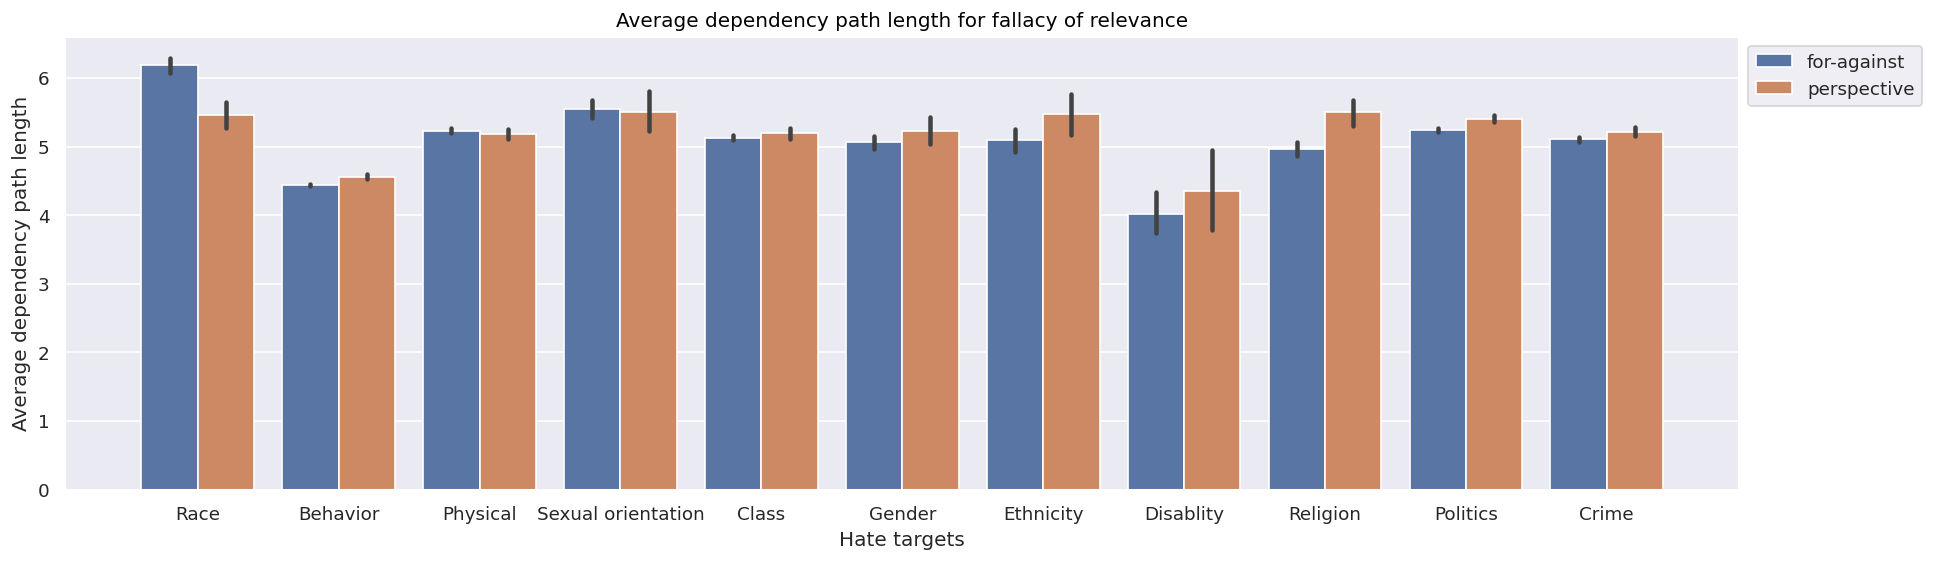

In [189]:
plot_average_dependency_path_length_distribution(classes_selected[0])

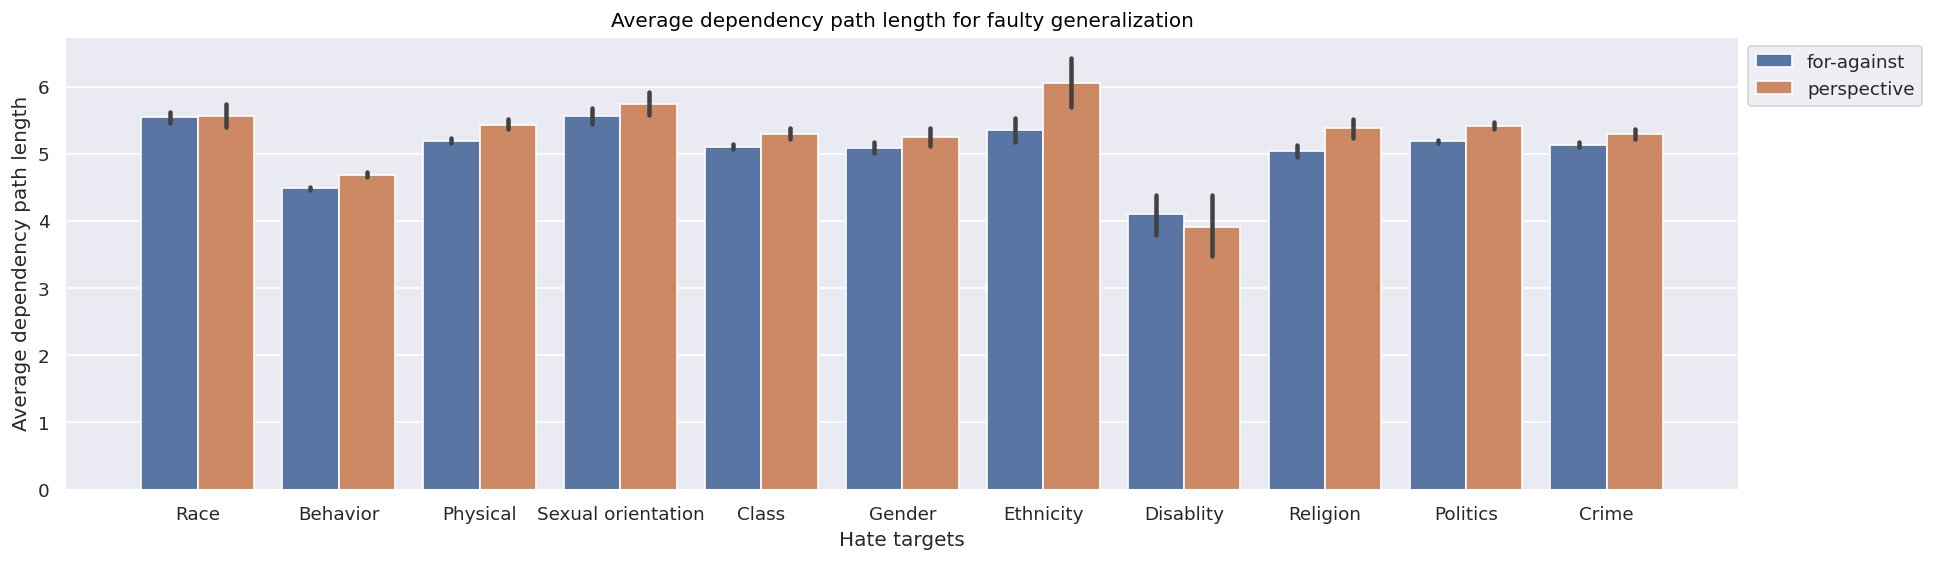

In [188]:
plot_average_dependency_path_length_distribution(classes_selected[1])

## Popular dependency paths

In [198]:
for_against_trigger_count_by_path_ordered = dict()
perspective_trigger_count_by_path_ordered = dict()

for cls in classes_selected:
    for_against_trigger_count_by_path_ordered[cls] = dict()
    perspective_trigger_count_by_path_ordered[cls] = dict()
    
    for hate_type in hate_targets.keys():
        for_against_trigger_count_by_path_ordered[cls][hate_type] = list()
        perspective_trigger_count_by_path_ordered[cls][hate_type] = list()

        for k, v in for_against_trigger_count_by_path[cls][hate_type].items():
            for_against_trigger_count_by_path_ordered[cls][hate_type].append((k, v))

        for k, v in perspective_trigger_count_by_path[cls][hate_type].items():
            perspective_trigger_count_by_path_ordered[cls][hate_type].append((k, v))

        for_against_trigger_count_by_path_ordered[cls][hate_type] = \
            sorted(for_against_trigger_count_by_path_ordered[cls][hate_type],
                   key=lambda z: z[1], reverse=True)
            
        perspective_trigger_count_by_path_ordered[cls][hate_type] = \
            sorted(perspective_trigger_count_by_path_ordered[cls][hate_type],
                   key=lambda z: z[1], reverse=True)

In [199]:
for cls in classes_selected:
    for hate_type in hate_targets.keys():
        print(f'For-against - {cls} - {hate_type}')
        for i in range(10):
            k, v = for_against_trigger_count_by_path_ordered[cls][hate_type][i]
            print(f'{k} (x{v})')
        print(f'\nPerspective - {cls} - {hate_type}')
        for i in range(10):
            k, v = perspective_trigger_count_by_path_ordered[cls][hate_type][i]
            print(f'{k} (x{v})')
        print('\n\n' + '-' * 100 + '\n\n')

For-against - fallacy of relevance - Race
amod->nsubj->ccomp->nsubj (x43)
acomp->nsubj (x40)
amod->dobj->nsubj (x39)
amod->pobj->prep->nsubj (x24)
amod->nsubj->advcl->nsubj (x22)
nsubj->ccomp->nsubj (x17)
amod->attr->nsubj (x14)
dobj->nsubj (x13)
amod->dobj->ccomp->nsubj (x13)
pobj->prep->nsubj (x13)

Perspective - fallacy of relevance - Race
amod->dobj->nsubj (x11)
acomp->advcl->nsubj (x9)
acomp->nsubj (x9)
amod->pobj->prep->nsubj (x9)
dobj->nsubj (x7)
amod->attr->nsubj (x7)
amod->nsubj->advcl->nsubj (x5)
amod->nsubj->ccomp->nsubj (x5)
amod->relcl->nsubj (x4)
amod->dobj->ccomp->nsubj (x4)


----------------------------------------------------------------------------------------------------


For-against - fallacy of relevance - Behavior
nsubj (x4341)
ccomp->nsubj (x1997)
acomp->nsubj (x1978)
dobj->nsubj (x1404)
advcl->nsubj (x1386)
dobj (x1078)
conj->nsubj (x859)
pobj->prep->nsubj (x802)
xcomp->nsubj (x714)
acomp->ccomp->nsubj (x710)

Perspective - fallacy of relevance - Behavior
nsub

In [220]:
def plot_top_dependency_paths_for_against(cls, T):
    dependency_count_dict = dict()

    for hate_type in hate_targets.keys():
        for path, count in for_against_trigger_count_by_path[cls][hate_type].items():
            if path in dependency_count_dict:
                dependency_count_dict[path] += count
            else:
                dependency_count_dict[path] = count
    
    dependency_count_list = list()
    for k, v in dependency_count_dict.items():
        dependency_count_list.append((k, v))
    dependency_count_list = sorted(dependency_count_list, key=lambda z: z[1], reverse=True)

    top_dependencies = list()
    for i in range(T):
        top_dependencies.append(dependency_count_list[i][0])

    lookup = set(top_dependencies)

    dependency_by_hate_type = dict()
    for dependency in top_dependencies:
        dependency_by_hate_type[dependency] = dict()
        for hate_type in hate_targets.keys():
            dependency_by_hate_type[dependency][hate_type] = 0

    for hate_type in hate_targets.keys():
        for path, count in for_against_trigger_count_by_path[cls][hate_type].items():
            if path not in lookup:
                continue
            dependency_by_hate_type[path][hate_type] += count
    
    data = { 'dependency path': list() }
    for hate_type in hate_targets.keys():
        data[hate_type] = list()

    for dependency in top_dependencies:
        data['dependency path'].append(dependency)
        for hate_type in hate_targets.keys():
            data[hate_type].append(dependency_by_hate_type[dependency][hate_type])


    df = pd.DataFrame(data)
    ax = df.set_index('dependency path').plot(kind='bar', stacked=True)
    ax.set_title(f'Top dependency paths for {cls} in for-against debates', color='black')
    ax.set_xlabel('Dependency paths')
    ax.set_ylabel('Occurence')
    ax.set_xticklabels(top_dependencies, rotation=45, ha='right')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.plot()

In [226]:
def plot_top_dependency_paths_perspective(cls, T):
    dependency_count_dict = dict()

    for hate_type in hate_targets.keys():
        for path, count in perspective_trigger_count_by_path[cls][hate_type].items():
            if path in dependency_count_dict:
                dependency_count_dict[path] += count
            else:
                dependency_count_dict[path] = count
    
    dependency_count_list = list()
    for k, v in dependency_count_dict.items():
        dependency_count_list.append((k, v))
    dependency_count_list = sorted(dependency_count_list, key=lambda z: z[1], reverse=True)

    top_dependencies = list()
    for i in range(T):
        top_dependencies.append(dependency_count_list[i][0])

    lookup = set(top_dependencies)

    dependency_by_hate_type = dict()
    for dependency in top_dependencies:
        dependency_by_hate_type[dependency] = dict()
        for hate_type in hate_targets.keys():
            dependency_by_hate_type[dependency][hate_type] = 0

    for hate_type in hate_targets.keys():
        for path, count in perspective_trigger_count_by_path[cls][hate_type].items():
            if path not in lookup:
                continue
            dependency_by_hate_type[path][hate_type] += count
    
    data = { 'dependency path': list() }
    for hate_type in hate_targets.keys():
        data[hate_type] = list()

    for dependency in top_dependencies:
        data['dependency path'].append(dependency)
        for hate_type in hate_targets.keys():
            data[hate_type].append(dependency_by_hate_type[dependency][hate_type])


    df = pd.DataFrame(data)
    ax = df.set_index('dependency path').plot(kind='bar', stacked=True)
    ax.set_title(f'Top dependency paths for {cls} in perspective debates', color='black')
    ax.set_xlabel('Dependency paths')
    ax.set_ylabel('Occurence')
    ax.set_xticklabels(top_dependencies, rotation=45, ha='right')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.plot()

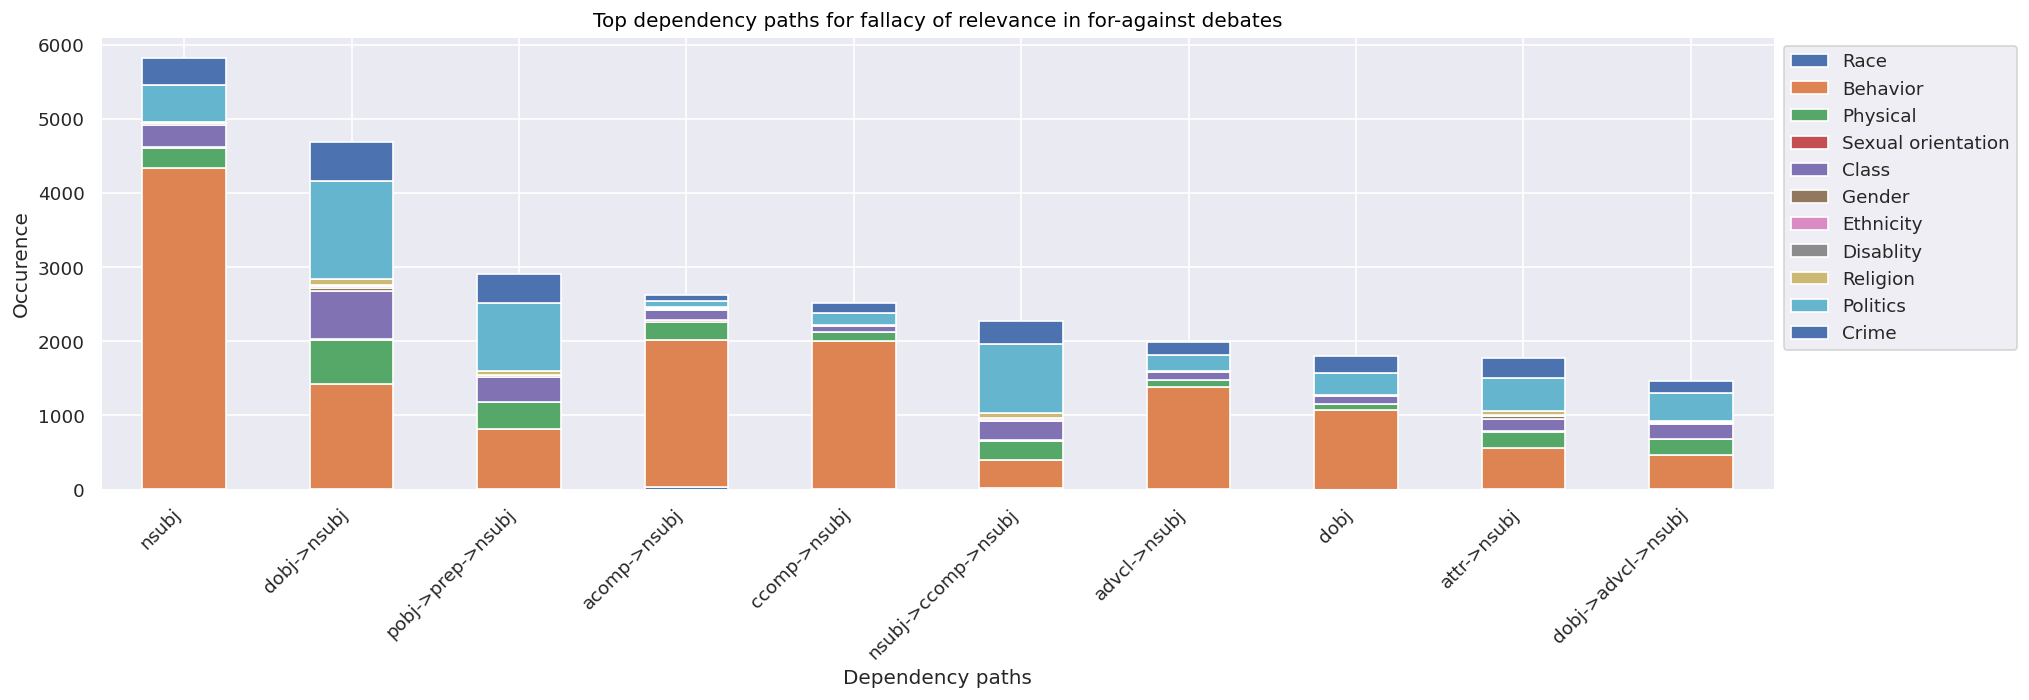

In [224]:
plot_top_dependency_paths_for_against('fallacy of relevance', 10)

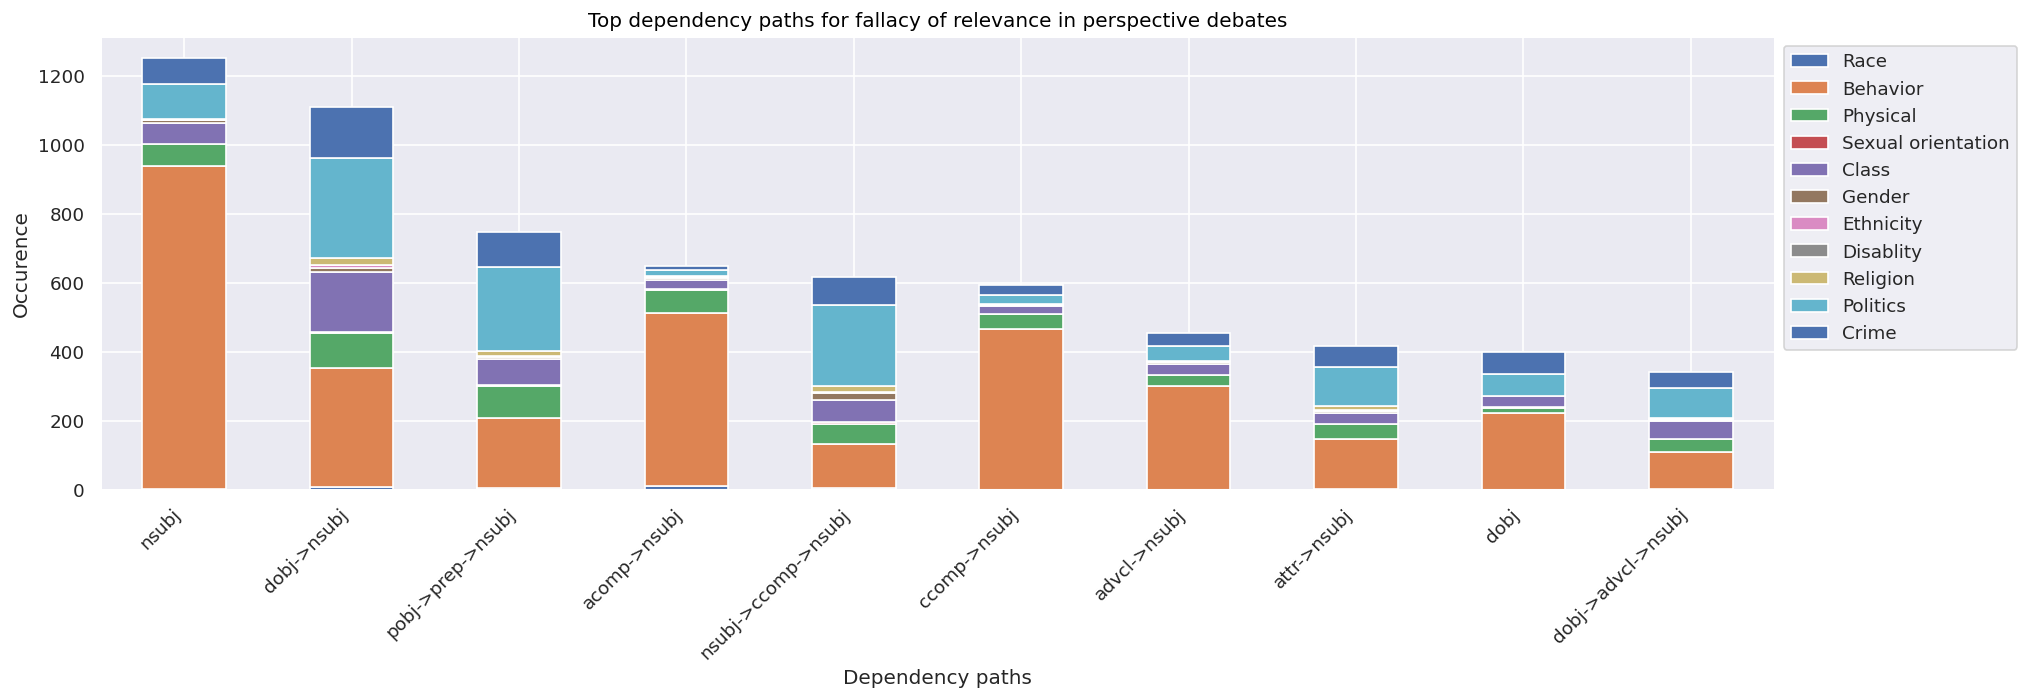

In [227]:
plot_top_dependency_paths_perspective('fallacy of relevance', 10)

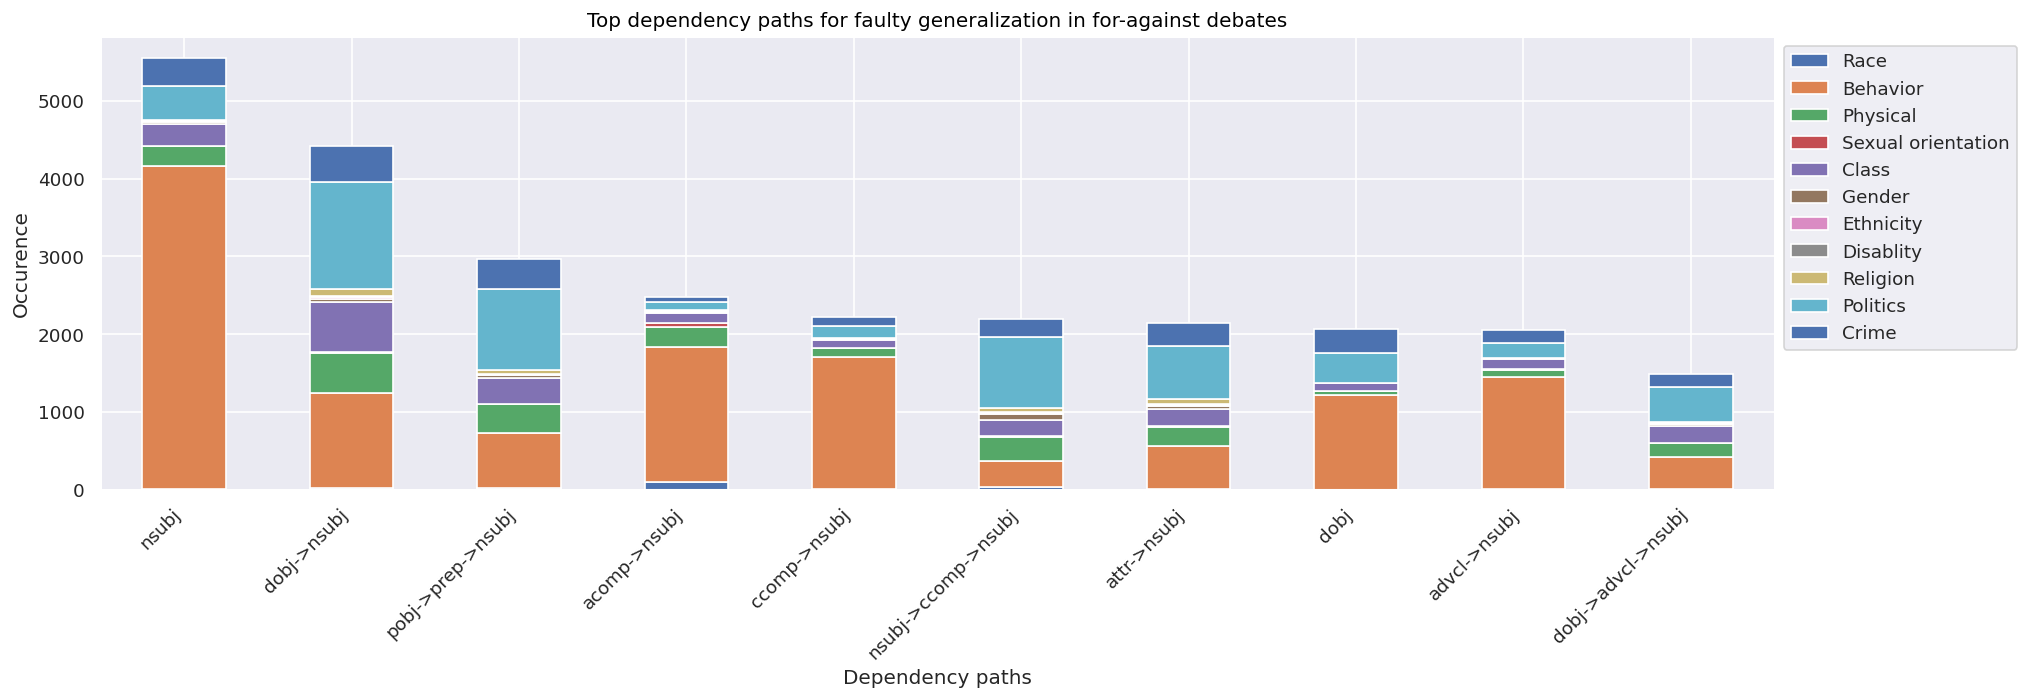

In [228]:
plot_top_dependency_paths_for_against('faulty generalization', 10)

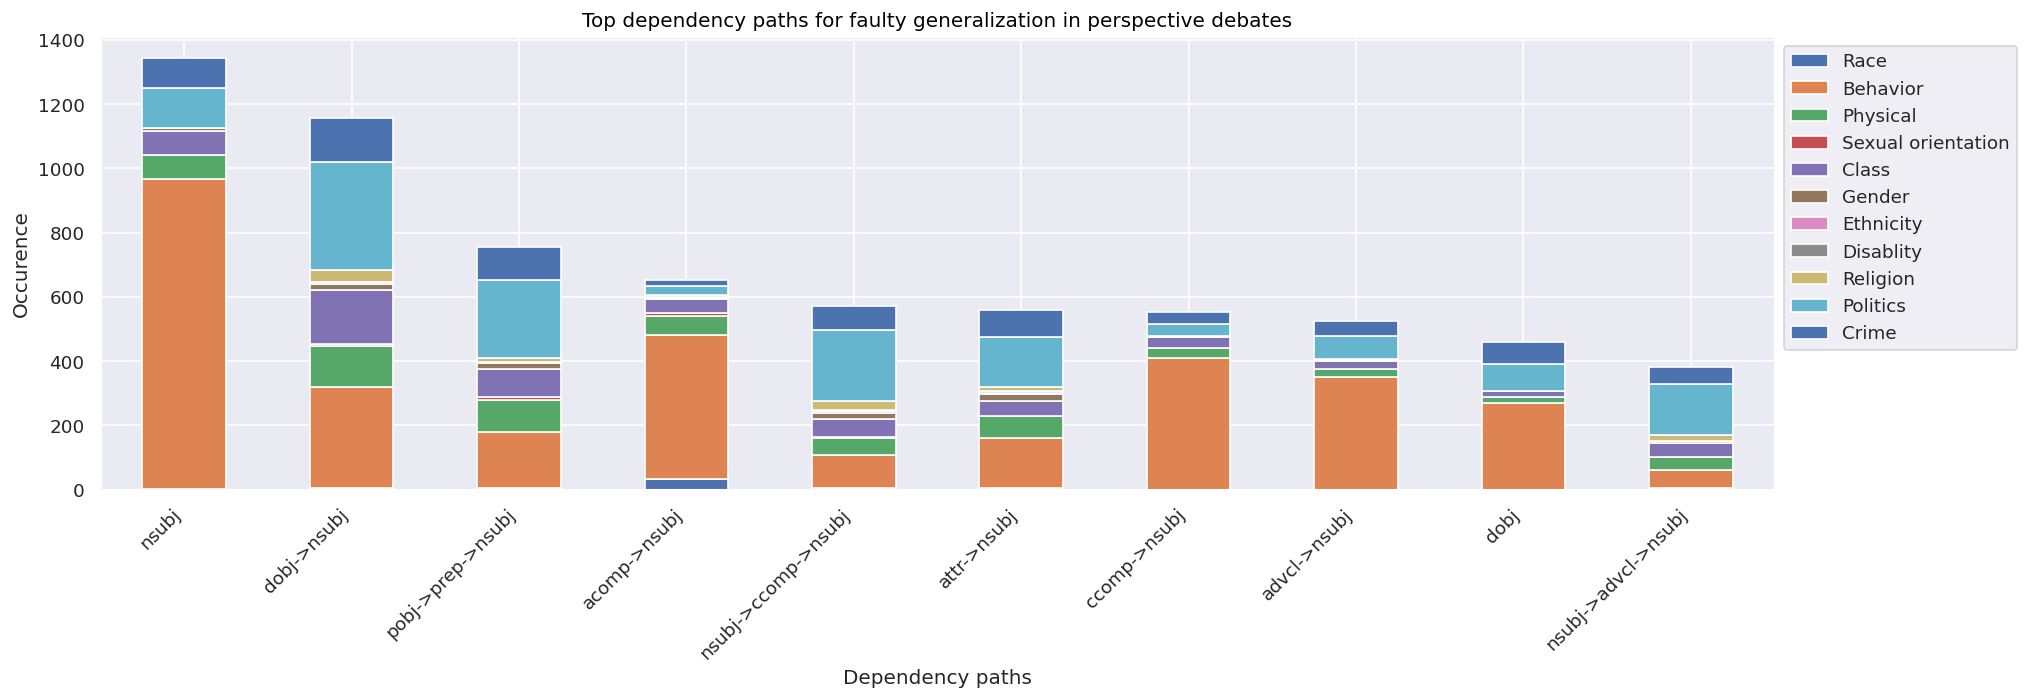

In [229]:
plot_top_dependency_paths_perspective('faulty generalization', 10)

In [238]:
def get_top_dependency_paths_for_against(cls):
    dependency_count_dict = dict()

    for hate_type in hate_targets.keys():
        for path, count in for_against_trigger_count_by_path[cls][hate_type].items():
            if path in dependency_count_dict:
                dependency_count_dict[path] += count
            else:
                dependency_count_dict[path] = count
    
    dependency_count_list = list()
    for k, v in dependency_count_dict.items():
        dependency_count_list.append((k, v))
    dependency_count_list = sorted(dependency_count_list, key=lambda z: z[1], reverse=True)

    top_dependencies = list()
    for i in range(len(dependency_count_list)):
        top_dependencies.append(dependency_count_list[i][0])
    
    return top_dependencies

In [239]:
def get_top_dependency_paths_perspective(cls):
    dependency_count_dict = dict()

    for hate_type in hate_targets.keys():
        for path, count in perspective_trigger_count_by_path[cls][hate_type].items():
            if path in dependency_count_dict:
                dependency_count_dict[path] += count
            else:
                dependency_count_dict[path] = count
    
    dependency_count_list = list()
    for k, v in dependency_count_dict.items():
        dependency_count_list.append((k, v))
    dependency_count_list = sorted(dependency_count_list, key=lambda z: z[1], reverse=True)

    top_dependencies = list()
    for i in range(len(dependency_count_list)):
        top_dependencies.append(dependency_count_list[i][0])
    
    return top_dependencies

In [244]:
def plot_jacquard_overlap():
    data = {
        'k': list(),
        'overlap': list(),
        'fallacy': list()
    }

    for cls in classes_selected:
        print(cls)
        for_against_set = get_top_dependency_paths_for_against(cls)
        perspective_set = get_top_dependency_paths_perspective(cls)
        limit = min(len(for_against_set), len(perspective_set))
        
        for idx in tqdm(range(1, limit + 1)):
            foo = set(for_against_set[:idx])
            bar = set(perspective_set[:idx])
            u = (foo | bar)
            i = (foo & bar)
            overlap = len(i) / len(u)
            data['k'].append(idx)
            data['overlap'].append(overlap)
            data['fallacy'].append(cls)

    ax = sns.lineplot(data=data, x='k', y='overlap', hue='fallacy')
    ax.set_title('Jacquard overlap', color='black')
    ax.set_xlabel('Top-K dependencies')
    ax.set_ylabel('Overlap')
    plt.xscale('log')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.plot()

fallacy of relevance


100%|██████████| 15763/15763 [00:44<00:00, 352.54it/s]


faulty generalization


100%|██████████| 17924/17924 [00:56<00:00, 315.46it/s]


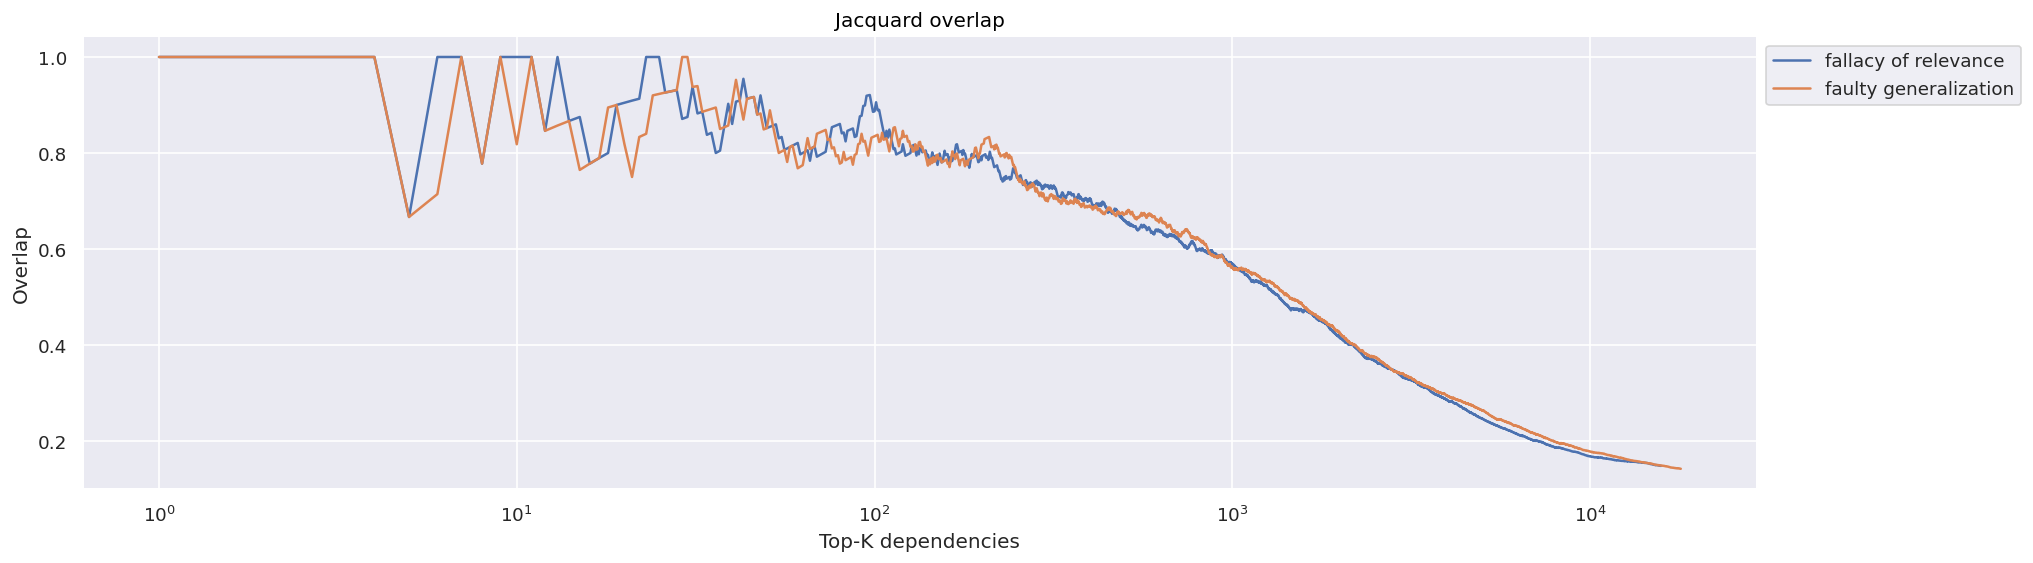

In [245]:
plot_jacquard_overlap()

In [250]:
def plot_path_length_vs_popularity():
    data = {
        'rank': list(),
        'path length': list(),
        'fallacy': list()
    }

    for cls in classes_selected:
        print(cls)
        for_against_set = get_top_dependency_paths_for_against(cls)
        perspective_set = get_top_dependency_paths_perspective(cls)
        limit = min(len(for_against_set), len(perspective_set))

        for i in tqdm(range(limit)):
            data['rank'].append(i + 1)
            data['path length'].append(len(for_against_set[i].split('->')))
            data['fallacy'].append(f'{cls} - for-against')
            data['rank'].append(i + 1)
            data['path length'].append(len(perspective_set[i].split('->')))
            data['fallacy'].append(f'{cls} - perspective')

    ax = sns.lineplot(data=data, x='rank', y='path length', hue='fallacy')
    ax.set_title('Variation of dependency path length with rank', color='black')
    ax.set_xlabel('Rank')
    ax.set_ylabel('Path length')
    plt.xscale('log')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.plot()

fallacy of relevance


100%|██████████| 15763/15763 [00:00<00:00, 326169.16it/s]

faulty generalization



100%|██████████| 17924/17924 [00:00<00:00, 369150.98it/s]


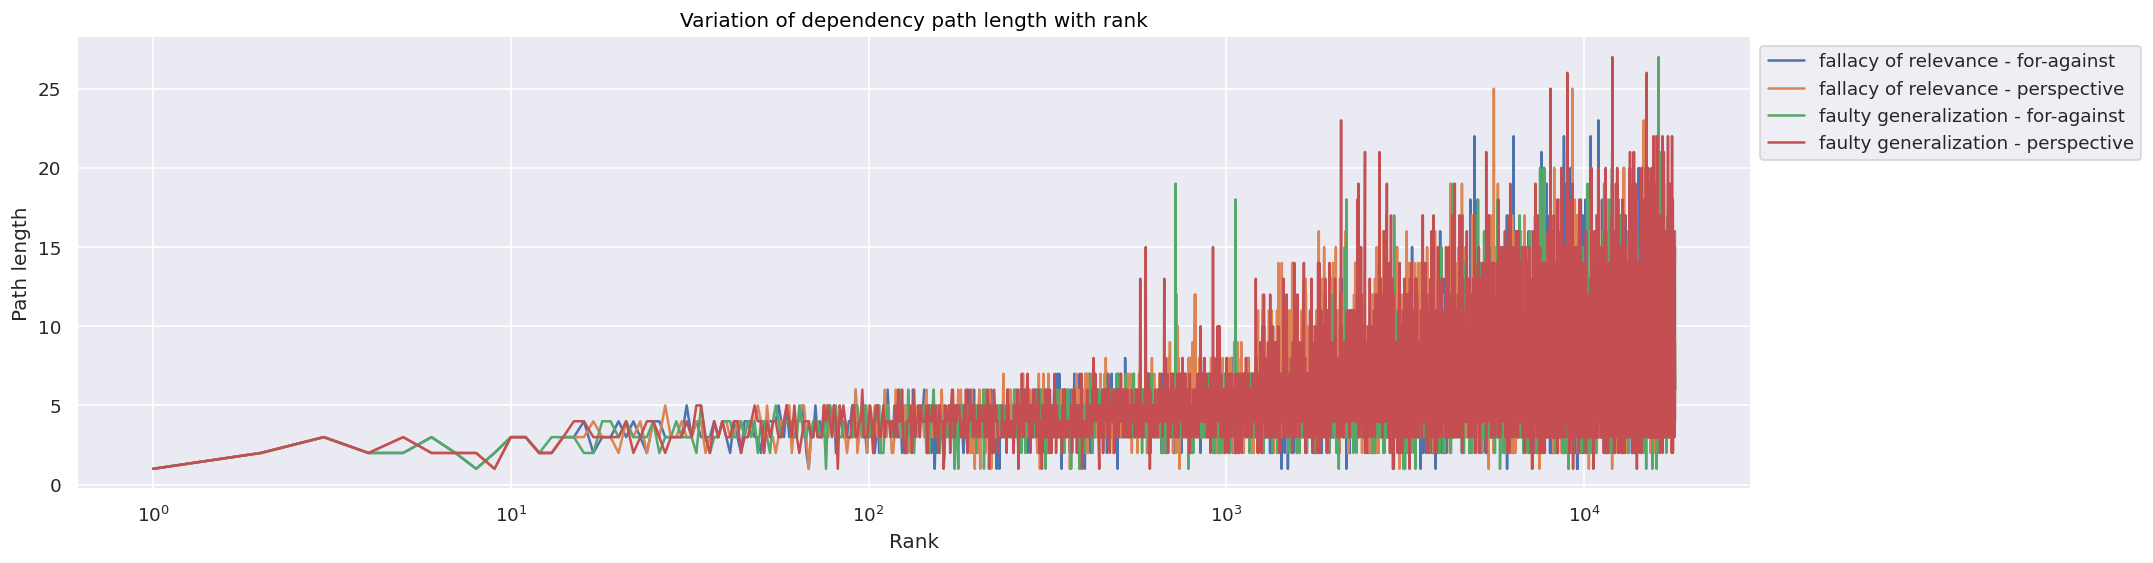

In [251]:
plot_path_length_vs_popularity()